#DnCNN

##Download dataset

In [1]:
!gdown https://drive.google.com/uc?id=1qxQL3Dhw8-q4Emmb6bT8T2LkZ0jheoMu

Downloading...
From: https://drive.google.com/uc?id=1qxQL3Dhw8-q4Emmb6bT8T2LkZ0jheoMu
To: /content/dblocking-dataset.zip
67.5MB [00:01, 36.1MB/s]


In [0]:
local_zip = 'dblocking-dataset.zip'

import zipfile
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(local_zip[:-4])
zip_ref.close()

##Visualize JPEG compression

In [0]:
# Perform JPEG compression
import io
from PIL import Image
def compress_image(img, quality = 10, display_image = False):
    """ Perform JPEG compression
    @params:
    img : PIL object
    quality :  Quality values must be in the range [0, 100]. Small quality values result in more compression and stronger compression artifacts.
    
    Returns:
    PIL compressed image object
    """
    buffer = io.BytesIO() #using a buffer in case we do not wish to save it in memory
    img.save(buffer, "JPEG", quality=quality)
    buffer.seek(0)
    compressed_image = Image.open(io.BytesIO(buffer.read()))
    
    if display_image == True:
        print("compressed image")
        display(compressed_image)
        
    return compressed_image

compressed image


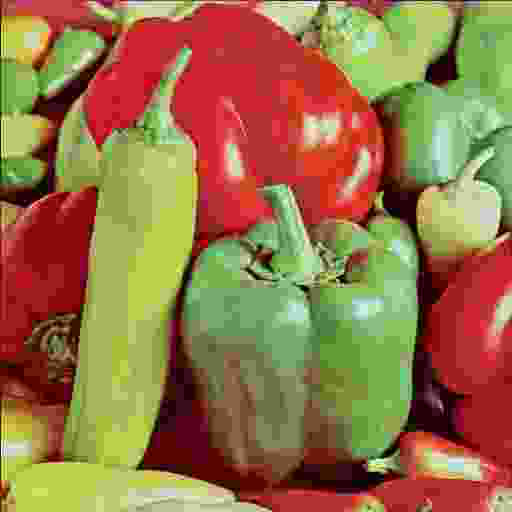

In [4]:
img_path = '/content/dblocking-dataset/validation/set14-downgraded/pepper.png'
img = Image.open(img_path)
compressed_image = compress_image(img, quality = 5, display_image = True)

##Generate dataset

In [0]:
'''Workflow:
 
 1. For each image in the provided train folder, patches are cut out of the image (patch size -> 50*50 with stride of 10)
 2. Each patch is randomly rotated and compressed into quality in range of [5,10,50,90,100]
 3. The compressed patch is subtracted from the original patch to get the artifact data (residual data)
 4. The compressed patch becomes the i/p to the network and the artifact is learnt by the model (o/p)
 5. Once the model is trained a compressed image is given to the network and the artifact produced by the network is subtracted from the compressed image 
 and SSIM score is calculated b/w original clean image and compressed image  and b/w original clean image and output image
 '''

In [0]:
# https://github.com/husqin/DnCNN-keras/blob/master/data.py
import glob
import os
import cv2
import numpy as np
from multiprocessing import Pool

aug_times = 1

def data_aug(img, mode=0):
    """Data augmentation
    
    Notes:
    1. The flipud() function is used to flip an given array in the up/down direction.
    2. np.rot90 -> k : Number of times the array is rotated by 90 degrees.
    """
    
    if mode == 0:
        return img
    elif mode == 1:
        return np.flipud(img)
    elif mode == 2:
        return np.rot90(img)
    elif mode == 3:
        return np.flipud(np.rot90(img))
    elif mode == 4:
        return np.rot90(img, k=2)
    elif mode == 5:
        return np.flipud(np.rot90(img, k=2))
    elif mode == 6:
        return np.rot90(img, k=3)
    elif mode == 7:
        return np.flipud(np.rot90(img, k=3))
    
def gen_patches(file_name):
    """ Patches are cropped out of the i/p image 
    after scaling it into 4 versions([1, 0.9, 0.8, 0.7])
    
    Data augmentation is performed along with it
    """
    # read image
    img = cv2.imread(file_name, 0)  # gray scale
    img = cv2.resize(img, (250,250), interpolation=cv2.INTER_CUBIC)
    
    h, w = img.shape
    scales = [1, 0.9, 0.8, 0.7]
    patches = []

    for s in scales:
        h_scaled, w_scaled = int(h*s),int(w*s)
        img_scaled = cv2.resize(img, (h_scaled,w_scaled), interpolation=cv2.INTER_CUBIC)
        # extract patches
        for i in range(0, h_scaled-patch_size+1, stride):
            for j in range(0, w_scaled-patch_size+1, stride):
                x = img_scaled[i:i+patch_size, j:j+patch_size]
                # data aug
                for k in range(0, aug_times):
                    x_aug = data_aug(x, mode=np.random.randint(0,8))
                    patches.append(x_aug)
    
    return patches

In [6]:
file_list = glob.glob('/content/dblocking-dataset/train/*/*.bmp')[:176] # Train data
print("{} images found in train folder".format(len(file_list)))


save_dir = '/content/train/npy_data/'

num_threads = 16    

# initialize
res = []
patch_size, stride = 50, 10 #patch size is 50*50

# generate patches
for i in range(0,len(file_list),num_threads):
    # use multi-process to speed up
    p = Pool(num_threads)
    patch = p.map(gen_patches,file_list[i:min(i+num_threads,len(file_list))])
    for x in patch:
        res += x

    print('Images '+str(i)+' to '+str(i+num_threads)+' processed...')

    
    
# save to .npy
res = np.array(res)
print('Shape of result = ' + str(res.shape))
print('Saving data...')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
np.save(save_dir+'clean_patches.npy', res)


176 images found in train folder
Images 0 to 16 processed...
Images 16 to 32 processed...
Images 32 to 48 processed...
Images 48 to 64 processed...
Images 64 to 80 processed...
Images 80 to 96 processed...
Images 96 to 112 processed...
Images 112 to 128 processed...
Images 128 to 144 processed...
Images 144 to 160 processed...
Images 160 to 176 processed...
Shape of result = (209440, 50, 50)
Saving data...


##Create compressed patches

In [0]:
train_data_clean = "/content/train/npy_data/clean_patches.npy"
data = np.load(train_data_clean)

In [8]:
import random

c_data = [] #np.zeros(data.shape)
for idx, img in enumerate(data[:]):
#     print(img.shape)
    print(idx)
    img = Image.fromarray(img)
    
    q = random.choice([5,10,50,90,100])
    c_img = compress_image(img, quality = q, display_image = False) #compressed image
    c_img = np.array(c_img)
    c_data.append(c_img)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
save_dir = '/content/train/npy_data/'

In [10]:
c_data = np.array(c_data)
print('Shape of result = ' + str(c_data.shape))
print('Saving data...')
if not os.path.exists(save_dir):
    os.makedir(save_dir)
np.save(save_dir+'compressed_patches.npy', c_data)

Shape of result = (209440, 50, 50)
Saving data...


##Data generator

In [0]:
import numpy as np

In [12]:
train_data_clean = "/content/train/npy_data/clean_patches.npy"
data = np.load(train_data_clean)
print('Size of train data: ({}, {}, {})'.format(data.shape[0],data.shape[1],data.shape[2]))

Size of train data: (209440, 50, 50)


In [0]:
data = data.reshape((data.shape[0],data.shape[1],data.shape[2],1))
data = data.astype('float32')/255.0

In [14]:
train_data_compressed = "/content/train/npy_data/compressed_patches.npy"
c_data = np.load(train_data_compressed)
print('Size of train data: ({}, {}, {})'.format(data.shape[0],data.shape[1],data.shape[2]))

Size of train data: (209440, 50, 50)


In [0]:
c_data = c_data.reshape((data.shape[0],data.shape[1],data.shape[2],1))
c_data = c_data.astype('float32')/255.0

In [0]:
def train_datagen(y_, c_data, batch_size=8):
    """
    Generator to yield data to the network
    
    @params:
    y_ : tensor of clean patches
    c_data  tensor of compressed patches
    
    Returns:
    ge_batch_x, artifacts : i/p, o/p for the network
    """

    indices = list(range(y_.shape[0]))
    while(True):
        np.random.shuffle(indices)    # shuffle
        
        for i in range(0, int(len(indices)), batch_size):
            ge_batch_y = y_[indices[i:i+batch_size]] #clean images batch
            artifacts = c_data[indices[i:i+batch_size]] - y_[indices[i:i+batch_size]] #subtract the grayscale images to get the artifacts batch

            ge_batch_x = ge_batch_y + artifacts  # input image = clean image + artifacts
            yield ge_batch_x, artifacts

##Model

In [18]:
from keras.models import *
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract

Using TensorFlow backend.


In [19]:
# confirm channel order
from keras import backend as K
print(K.image_data_format())

channels_last


In [0]:
def DnCNN():
    
    inpt = Input(shape=(None,None,1))
    # 1st layer, Conv+relu
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
    x = Activation('relu')(x)
    # 15 layers, Conv+BN+relu
    for i in range(15):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
#         x = BatchNormalization(axis=-1, epsilon=1e-3)(x)
        x = Activation('relu')(x)   
    # last layer, Conv
    x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Subtract()([inpt, x])   # input - artifacts
    model = Model(inputs=inpt, outputs=x)
    
    return model

In [21]:
model = DnCNN()

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 6 36928       activation_1[0][0]               
____________________________________________________________________________________________

##Train

In [0]:
batch_size = 128
lr = 0.001
save_every = 10 #save model h5 after every "n" epochs
epoch = 10

In [0]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [0]:
save_dir = '/content/train/'

In [0]:
def step_decay(epoch,lr):
    """
    Learning rate scheduler, decrease learning rate by 10 after 50 eopchs
    
    @params:
    epoch : Num of epochs 
    lr : Learning rate
    
    Returns:
    lr : Learning rate (callback)
    """
    
    initial_lr = lr
    if epoch<50:
        lr = initial_lr
    else:
        lr = initial_lr/10

    return lr

In [28]:
# compile the model
model.compile(optimizer=Adam(), loss=['mse'])

# use call back functions
ckpt = ModelCheckpoint(save_dir+'/model_{epoch:02d}.h5', monitor='val_loss', 
                verbose=0, period=save_every)

lr = LearningRateScheduler(step_decay)

# train 
history = model.fit_generator(train_datagen(data, c_data, batch_size=batch_size),
                steps_per_epoch=int(len(data)/10)//batch_size, epochs=epoch, verbose=1, 
                callbacks=[ckpt, lr]) #decreased the num of steps to reduce training time by dividng by 10




Epoch 1/10
163/163 [==============================] - 99s 605ms/step - loss: 0.0153
Epoch 2/10
163/163 [==============================] - 92s 565ms/step - loss: 0.0022
Epoch 3/10
163/163 [==============================] - 92s 563ms/step - loss: 0.0952
Epoch 4/10
163/163 [==============================] - 91s 558ms/step - loss: 0.0091
Epoch 5/10
163/163 [==============================] - 91s 559ms/step - loss: 0.0030
Epoch 6/10
163/163 [==============================] - 91s 560ms/step - loss: 0.0020
Epoch 7/10
163/163 [==============================] - 91s 560ms/step - loss: 0.0018
Epoch 8/10
163/163 [==============================] - 91s 560ms/step - loss: 0.0017
Epoch 9/10
163/163 [==============================] - 91s 560ms/step - loss: 0.0016
Epoch 10/10
163/163 [==============================] - 91s 559ms/step - loss: 0.0016


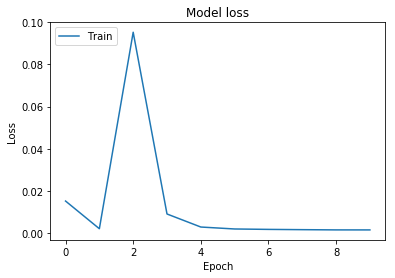

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Test

In [0]:
# Load model
import os
from keras.models import load_model
source_dir = "/content/train"
model_name = "model_10"
model = load_model(os.path.join(source_dir,model_name+".h5"))
print("Loaded model from disk",model_name)








Loaded model from disk model_10


19 images found in test folder
0 /content/dblocking-dataset/validation/Set5/woman.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


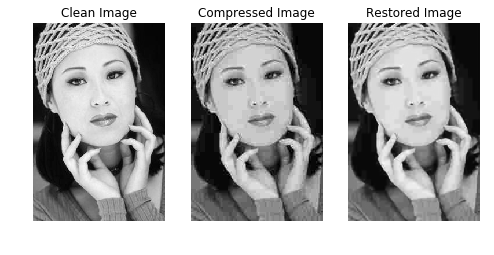

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9154723190116828 0.9349656344433985
psnr_clean_vs_test, psnr_clean_vs_predicted -> 28.438126696590107 29.308165185800977
********************************************************************************
1 /content/dblocking-dataset/validation/Set5/bird.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


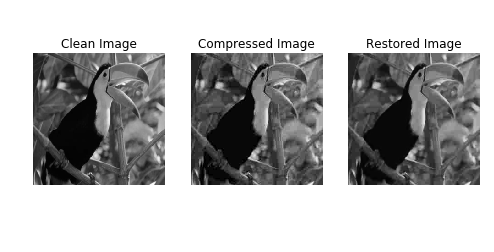

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9163144883299303 0.9380876565281127
psnr_clean_vs_test, psnr_clean_vs_predicted -> 30.372908223488192 31.403143014404044
********************************************************************************
2 /content/dblocking-dataset/validation/Set5/butterfly.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


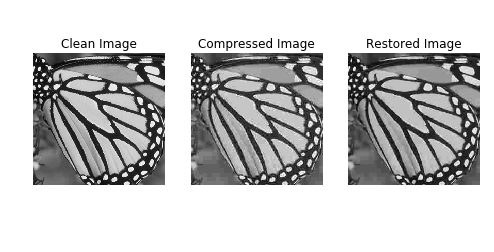

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8979807914649492 0.9307759791027459
psnr_clean_vs_test, psnr_clean_vs_predicted -> 25.24429691813417 26.85700523250468
********************************************************************************
3 /content/dblocking-dataset/validation/Set5/baby.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


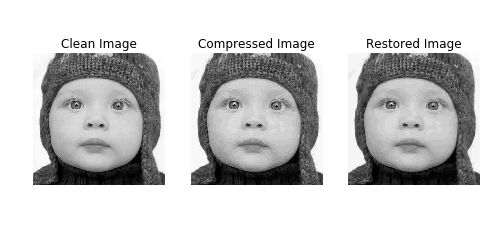

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9170561223606173 0.9305306120730354
psnr_clean_vs_test, psnr_clean_vs_predicted -> 30.892128797180685 30.881089641307554
********************************************************************************
4 /content/dblocking-dataset/validation/Set5/head.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


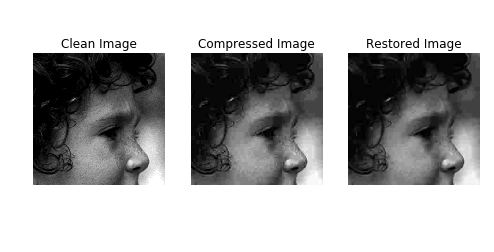

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.854856308720513 0.8680751712827623
psnr_clean_vs_test, psnr_clean_vs_predicted -> 30.006942299589316 30.3308537964135
********************************************************************************
5 /content/dblocking-dataset/validation/Set14/coastguard.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


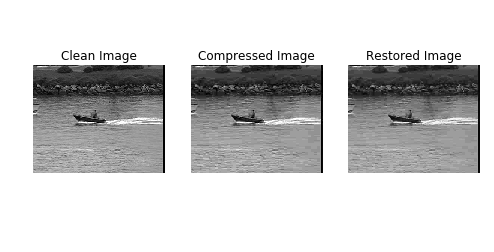

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8445582546686997 0.8501954869184766
psnr_clean_vs_test, psnr_clean_vs_predicted -> 27.455524493258963 27.742644116051203
********************************************************************************
6 /content/dblocking-dataset/validation/Set14/foreman.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


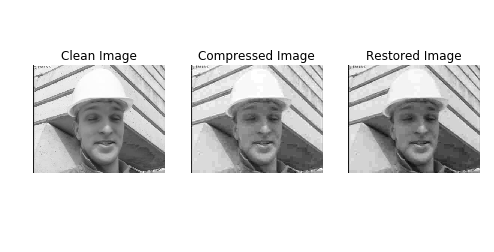

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.920225037765183 0.9401501951689846
psnr_clean_vs_test, psnr_clean_vs_predicted -> 29.554196683726204 29.466165378932565
********************************************************************************
7 /content/dblocking-dataset/validation/Set14/bridge.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


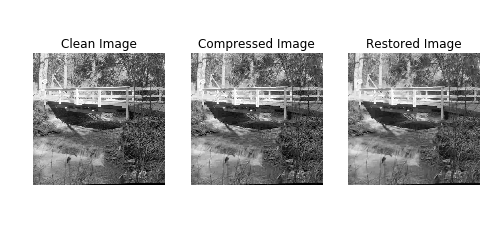

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8127904384048816 0.8229415785916618
psnr_clean_vs_test, psnr_clean_vs_predicted -> 25.12703776848675 25.52133664036529
********************************************************************************
8 /content/dblocking-dataset/validation/Set14/pepper.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


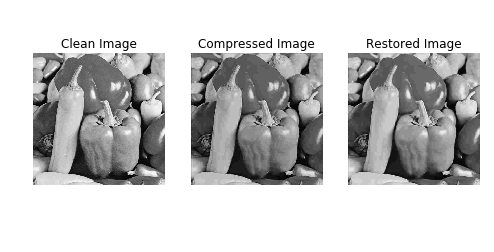

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9012280173343473 0.9201108778799167
psnr_clean_vs_test, psnr_clean_vs_predicted -> 30.14044664480258 30.729015621754158
********************************************************************************
9 /content/dblocking-dataset/validation/Set14/comic.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


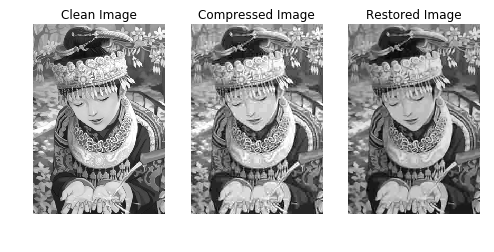

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8608576238365563 0.881562836139117
psnr_clean_vs_test, psnr_clean_vs_predicted -> 24.096936551439608 24.82375787269072
********************************************************************************
10 /content/dblocking-dataset/validation/Set14/face.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


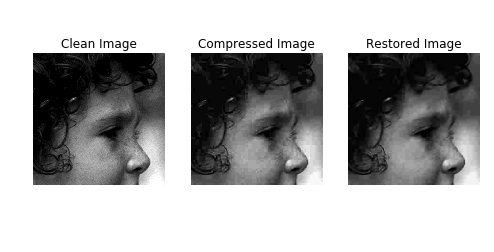

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8533467244189756 0.8676909571335562
psnr_clean_vs_test, psnr_clean_vs_predicted -> 29.960195339046347 30.332222603303048
********************************************************************************
11 /content/dblocking-dataset/validation/Set14/barbara.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


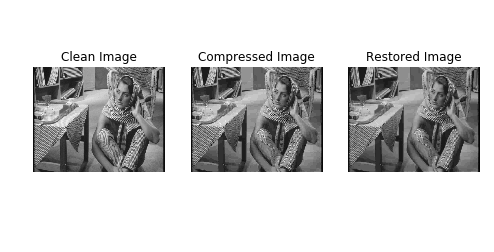

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8704153306380021 0.8839884960364149
psnr_clean_vs_test, psnr_clean_vs_predicted -> 26.461881638121113 27.011821655781784
********************************************************************************
12 /content/dblocking-dataset/validation/Set14/ppt3.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


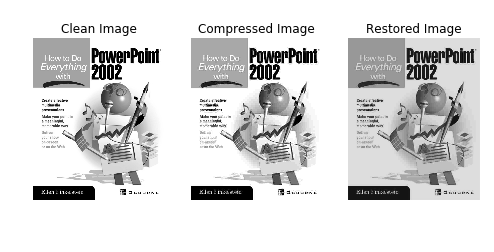

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9448206567280331 0.9574470682543238
psnr_clean_vs_test, psnr_clean_vs_predicted -> 28.32450267925049 28.39816254591139
********************************************************************************
13 /content/dblocking-dataset/validation/Set14/zebra.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


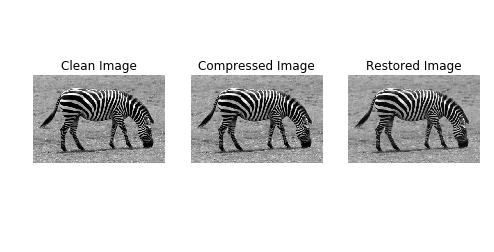

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8755632857717385 0.8908281886507937
psnr_clean_vs_test, psnr_clean_vs_predicted -> 27.386458176172606 28.057729560520816
********************************************************************************
14 /content/dblocking-dataset/validation/Set14/lenna.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


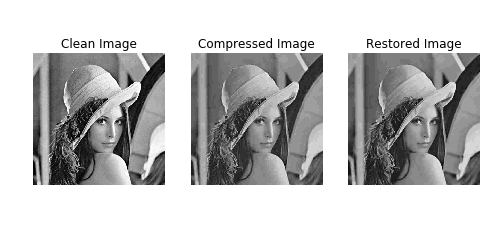

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9038991641189665 0.9189123943151591
psnr_clean_vs_test, psnr_clean_vs_predicted -> 30.025454979584005 30.522513735389435
********************************************************************************
15 /content/dblocking-dataset/validation/Set14/man.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


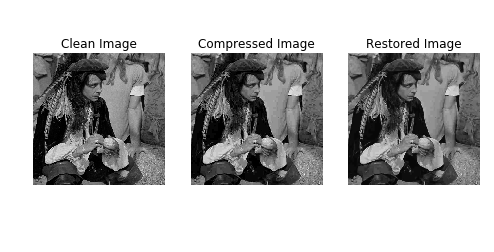

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8408084653461125 0.8567411564386678
psnr_clean_vs_test, psnr_clean_vs_predicted -> 26.482321117502757 27.078299901665428
********************************************************************************
16 /content/dblocking-dataset/validation/Set14/flowers.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


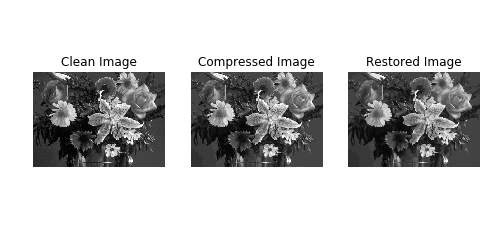

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.8778813846584103 0.8962494041916848
psnr_clean_vs_test, psnr_clean_vs_predicted -> 27.19250795553028 28.020199950741997
********************************************************************************
17 /content/dblocking-dataset/validation/Set14/monarch.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


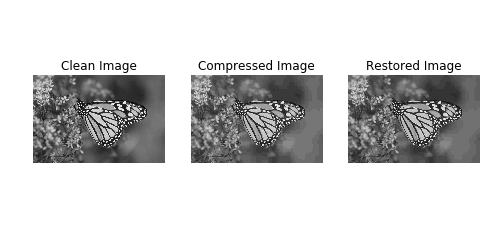

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9347164020348735 0.9530066510755668
psnr_clean_vs_test, psnr_clean_vs_predicted -> 29.475220034414953 30.69275202512845
********************************************************************************
18 /content/dblocking-dataset/validation/Set14/baboon.png
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


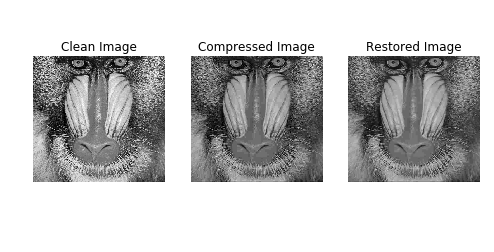

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.7701083275271818 0.7748798565078083
psnr_clean_vs_test, psnr_clean_vs_predicted -> 23.206353362782938 23.529630385883916
********************************************************************************
Average PSNR = 28.46, SSIM = 0.90


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import compare_psnr, compare_ssim
from google.colab.patches import cv2_imshow
import cv2
import glob
from PIL import Image

psnr = []
ssim = []

file_list = glob.glob('/content/dblocking-dataset/validation/[!set]*/*.png')
print("{} images found in test folder".format(len(file_list)))

for idx, file in enumerate(file_list[:]):
    print(idx, file)
    print("+"*100)

    fig=plt.figure(figsize=(8, 4))
    plt.gca().axis('off')
#     plt.gca().set_title('Redsidual DnCNN in Action')

    clean_img = Image.open(file).convert("L")
    fig.add_subplot(1, 3, 1)   # subplot one
    plt.gca().set_title('Clean Image')
    plt.gca().axis('off')
    plt.imshow(clean_img, cmap=plt.cm.gray)

    # compress the image
    compressed_img = compress_image(clean_img, quality = 10, display_image = False) #compressed image
    fig.add_subplot(1, 3, 2)   # subplot two
    plt.gca().set_title('Compressed Image')
    plt.gca().axis('off')
    plt.imshow(compressed_img, cmap=plt.cm.gray)


    # convert PIL objects (clean image and compressed image) to numpy arrays and pre-process them
    clean_img = np.array(clean_img, dtype='float32') / 255.0

    compressed_img = np.array(compressed_img, dtype='float32') / 255.0

    # test image will be the compressed image
    img_test = compressed_img 

    # predict the residual image
    img_test = img_test.reshape(1, img_test.shape[0], img_test.shape[1], 1) 
    residual_image = model.predict(img_test)

    residual_image = residual_image.reshape((compressed_img.shape[0], compressed_img.shape[1]))

    # subtract the residual image from the compressed image
    restored_image = compressed_img - residual_image
    fig.add_subplot(1, 3, 3)   # subplot two
    plt.gca().set_title('Restored Image')
    plt.gca().axis('off')
    plt.imshow(restored_image, cmap=plt.cm.gray)


    # calculate evaluation metrics
    # img_out = residual_image.reshape(img_clean.shape)
    # img_out = np.clip(img_out, 0, 1)
    psnr_clean_vs_test, psnr_clean_vs_predicted = compare_psnr(clean_img, compressed_img), compare_psnr(clean_img, restored_image)
    ssim_clean_vs_test, ssim_clean_vs_predicted = compare_ssim(clean_img, compressed_img), compare_ssim(clean_img, restored_image)
    psnr.append(psnr_clean_vs_predicted)
    ssim.append(ssim_clean_vs_predicted)
    
    plt.show()

    print("*"*80)
    print("Evaluation Metrics")
    print("ssim_clean_vs_test, ssim_clean_vs_predicted ->",ssim_clean_vs_test, ssim_clean_vs_predicted)
    print("psnr_clean_vs_test, psnr_clean_vs_predicted ->",psnr_clean_vs_test, psnr_clean_vs_predicted)
    print("*"*80)

psnr_avg = sum(psnr)/len(psnr)
ssim_avg = sum(ssim)/len(ssim)

print('Average PSNR = {0:.2f}, SSIM = {1:.2f}'.format(psnr_avg, ssim_avg))

##Prediction on a single image

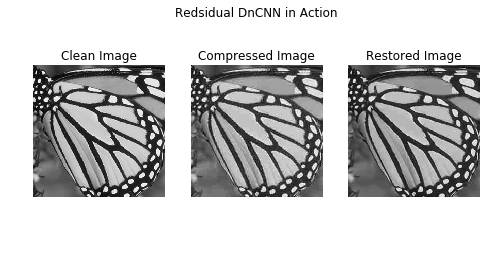

********************************************************************************
Evaluation Metrics
ssim_clean_vs_test, ssim_clean_vs_predicted -> 0.9230674598917905 0.9460206493777278
psnr_clean_vs_test, psnr_clean_vs_predicted -> 26.632442191066406 28.051921301367685
********************************************************************************


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import compare_psnr, compare_ssim
from google.colab.patches import cv2_imshow
import cv2


fig=plt.figure(figsize=(8, 4))
plt.gca().axis('off')
plt.gca().set_title('Redsidual DnCNN in Action')

# test image
file = '/content/dblocking-dataset/validation/Set5/butterfly.png'

clean_img = Image.open(file).convert("L")
fig.add_subplot(1, 3, 1)   # subplot one
plt.gca().set_title('Clean Image')
plt.gca().axis('off')
plt.imshow(clean_img, cmap=plt.cm.gray)

# compress the image
compressed_img = compress_image(clean_img, quality = 15, display_image = False) #compressed image
fig.add_subplot(1, 3, 2)   # subplot two
plt.gca().set_title('Compressed Image')
plt.gca().axis('off')
plt.imshow(compressed_img, cmap=plt.cm.gray)


# convert PIL objects (clean image and compressed image) to numpy arrays and pre-process them
clean_img = np.array(clean_img, dtype='float32') / 255.0

compressed_img = np.array(compressed_img, dtype='float32') / 255.0

# test image will be the compressed image
img_test = compressed_img 

# predict the residual image
img_test = img_test.reshape(1, img_test.shape[0], img_test.shape[1], 1) 
residual_image = model.predict(img_test)

residual_image = residual_image.reshape((compressed_img.shape[0], compressed_img.shape[1]))

# subtract the residual image from the compressed image
restored_image = compressed_img - residual_image
fig.add_subplot(1, 3, 3)   # subplot two
plt.gca().set_title('Restored Image')
plt.gca().axis('off')
plt.imshow(restored_image, cmap=plt.cm.gray)


# calculate evaluation metrics
# img_out = residual_image.reshape(img_clean.shape)
# img_out = np.clip(img_out, 0, 1)
psnr_clean_vs_test, psnr_clean_vs_predicted = compare_psnr(clean_img, compressed_img), compare_psnr(clean_img, restored_image)
ssim_clean_vs_test, ssim_clean_vs_predicted = compare_ssim(clean_img, compressed_img), compare_ssim(clean_img, restored_image)

plt.show()

print("*"*80)
print("Evaluation Metrics")
print("ssim_clean_vs_test, ssim_clean_vs_predicted ->",ssim_clean_vs_test, ssim_clean_vs_predicted)
print("psnr_clean_vs_test, psnr_clean_vs_predicted ->",psnr_clean_vs_test, psnr_clean_vs_predicted)
print("*"*80)




**ssim_clean_vs_predicted(predicted) is greater than ssim_clean_vs_test(compressed)**

**Hence we have acheived the goal of removing artifacts**

##Difference b/w compressed and clean image

Our goal was to find the residual image as shown in Figure 3

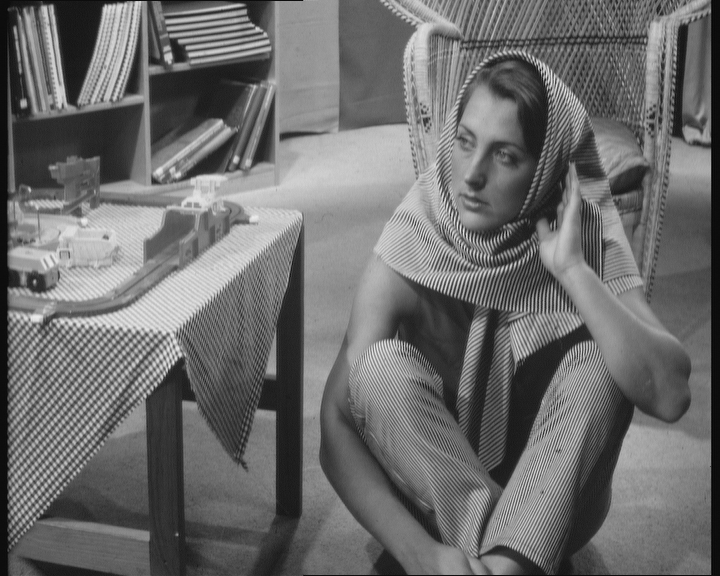

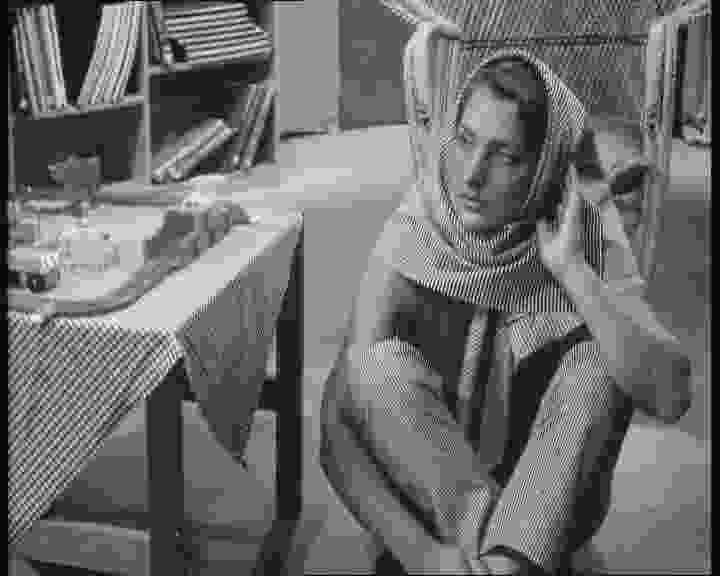

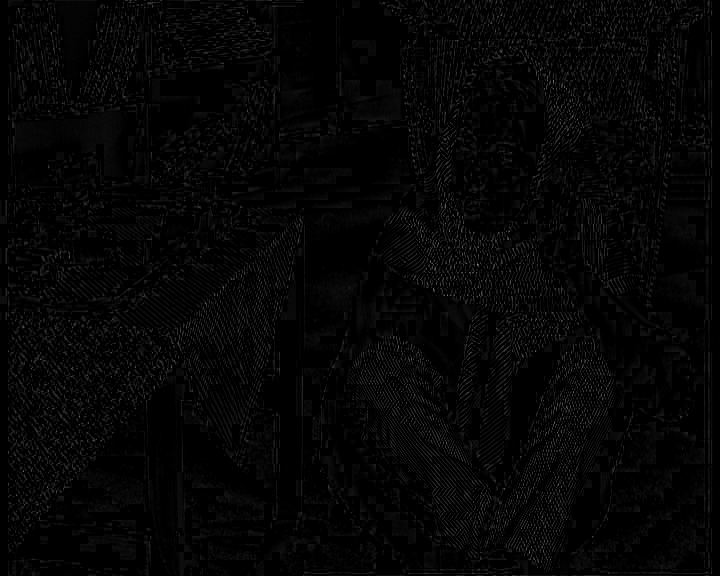

In [0]:
file = '/content/dblocking-dataset/validation/Set14/barbara.png'

img_clean = Image.open(file).convert("L")
display(img_clean)
# img_clean= Image.fromarray(img_clean)

c_img = compress_image(img_clean, quality = 5, display_image = False) #compressed image
display(c_img)

from PIL import ImageChops

diff = ImageChops.subtract(c_img, img_clean)
display(diff)

#Old work

##Download dataset

In [0]:
!gdown https://drive.google.com/uc?id=1qxQL3Dhw8-q4Emmb6bT8T2LkZ0jheoMu

Downloading...
From: https://drive.google.com/uc?id=1qxQL3Dhw8-q4Emmb6bT8T2LkZ0jheoMu
To: /content/dblocking-dataset.zip
67.5MB [00:00, 110MB/s] 


In [0]:
local_zip = 'dblocking-dataset.zip'

import zipfile
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(local_zip[:-4])
zip_ref.close()

##Visualization of JPEG compression 

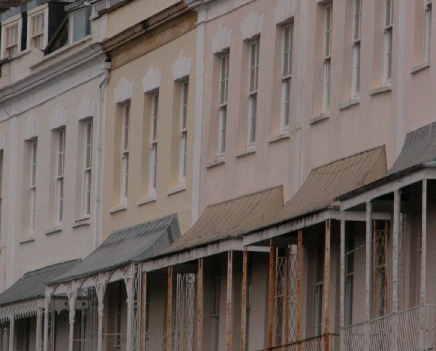

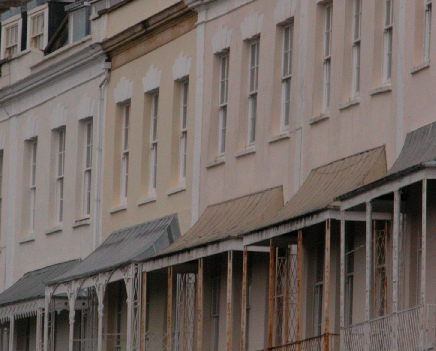

In [0]:
# from io import StringIO # "import StringIO" directly in python2
from PIL import Image
from io import BytesIO
import io

file_loc = "/content/dblocking-dataset/train/91/tt2.bmp"
input_image = Image.open(file_loc)
display(input_image)

buffer = BytesIO()
quality = 100
input_image.save(buffer, "JPEG", quality=quality)
buffer.seek(0)
output_image = Image.open(io.BytesIO(buffer.read()))
display(output_image)

#for sanity check
input_image.save('out.jpeg', quality=quality)


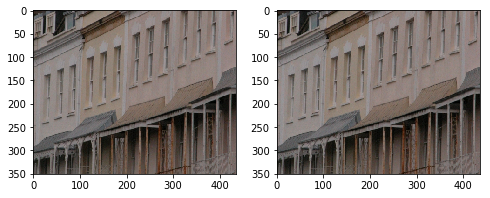

In [0]:
import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(8, 4))

# plot each image 
fig.add_subplot(1, 2, 1)   # subplot one
plt.imshow(input_image, cmap=plt.cm.gray)

fig.add_subplot(1, 2, 2)   # subplot two

plt.imshow(output_image, cmap="gray")  # use appropriate colormap here
plt.show()

##Conduct sanity check
https://www.pyimagesearch.com/2017/06/19/image-difference-with-opencv-and-python/


In [0]:
from skimage.measure import compare_ssim
import cv2
# load the two input images
imageA = cv2.imread(file_loc)
# imageB = cv2.imread("/content/dblocking-dataset/train/91/t27.bmp" ) #"out.jpeg"
imageB = cv2.imread("out.jpeg")
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

In [0]:
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.9994016419127654


##Check image size is constant or not

In [0]:
import os
source_dir = "/content/dblocking-dataset/train/General-100/"
for idx,i in enumerate(os.listdir(source_dir)):
    img = Image.open(os.path.join(source_dir,i))
    print(idx, img.size)

0 (454, 323)
1 (478, 366)
2 (488, 471)
3 (390, 455)
4 (770, 598)
5 (469, 407)
6 (294, 293)
7 (322, 279)
8 (503, 343)
9 (438, 384)
10 (356, 354)
11 (430, 416)
12 (688, 516)
13 (648, 518)
14 (335, 290)
15 (452, 468)
16 (283, 210)
17 (372, 481)
18 (636, 726)
19 (558, 516)
20 (451, 468)
21 (413, 339)
22 (468, 460)
23 (401, 425)
24 (448, 432)
25 (301, 275)
26 (323, 395)
27 (119, 127)
28 (504, 412)
29 (536, 476)
30 (446, 398)
31 (329, 286)
32 (456, 403)
33 (362, 395)
34 (207, 195)
35 (730, 526)
36 (380, 407)
37 (768, 582)
38 (267, 233)
39 (517, 440)
40 (262, 198)
41 (305, 216)
42 (582, 413)
43 (348, 408)
44 (343, 340)
45 (362, 395)
46 (356, 256)
47 (448, 420)
48 (356, 301)
49 (553, 411)
50 (208, 205)
51 (478, 356)
52 (480, 329)
53 (400, 426)
54 (524, 424)
55 (417, 279)
56 (302, 217)
57 (131, 112)
58 (277, 145)
59 (528, 717)
60 (353, 254)
61 (368, 277)
62 (585, 727)
63 (202, 135)
64 (181, 149)
65 (524, 517)
66 (381, 348)
67 (341, 199)
68 (549, 480)
69 (426, 419)
70 (526, 516)
71 (632, 458)
72

In [0]:
https://in.mathworks.com/help/images/jpeg-image-deblocking-using-deep-learning.html
    https://github.com/eriklindernoren/ML-From-Scratch/blob/master/mlfromscratch/unsupervised_learning/autoencoder.py

SyntaxError: ignored

##Autoencoder 

In [0]:
# import shutil
# shutil.rmtree("/content/train_data")

In [0]:
import os
import glob
dest_dir_1 = "train_data/clean/"
dest_dir_2 = "train_data/compressed/"

os.makedirs(dest_dir_1, exist_ok=True)
os.makedirs(dest_dir_2, exist_ok=True)

In [0]:
train_compressed = glob.glob('/content/dblocking-dataset/train/*/*.bmp')
source_dir = train_compressed


        
for idx,i in enumerate(source_dir):
    source_dir = "/".join(i.split("/")[:-1])
    i = i.split("/")[-1]
#     print("source_dir,i",source_dir,i)
    img = Image.open(os.path.join(source_dir,i))
    
    input_image.save(os.path.join(dest_dir_1,i[:-4]+".jpeg"))
    buffer = BytesIO()
    quality = 10

    input_image.save(os.path.join(dest_dir_2,i[:-4]+".jpeg"), quality=quality)
    

In [0]:
TRAIN_IMAGES = glob.glob('/content/train_data/compressed/*.jpeg')
CLEAN_IMAGES = glob.glob('/content/train_data/clean/*.jpeg')
TEST_IMAGES = glob.glob('/content/dblocking-dataset/validation/[!Set]*/*.png')

In [0]:
import os
import glob

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam, SGD, Adadelta
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D, Conv2DTranspose, MaxPool2D

Using TensorFlow backend.


In [0]:
def load_image(path):
    image_list = np.zeros((len(path), 260, 540, 3))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='rgb', target_size=(260, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

In [0]:
x_train = load_image(TRAIN_IMAGES)
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)

print(x_train.shape, x_test.shape)

(191, 260, 540, 3) (19, 260, 540, 3)


In [0]:
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)
print(x_train.shape, x_val.shape)

(152, 260, 540, 3) (39, 260, 540, 3)


##AutoEncoder Class

In [0]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 260
        self.img_cols = 540
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.001)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        # decoder
        h = Conv2D(128, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

In [0]:
# # Not performing well at restoration
# class Autoencoder():
#     def __init__(self):
#         self.img_rows = 260
#         self.img_cols = 540
#         self.channels = 3
#         self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
#         optimizer = Adam(lr=0.0001)
        
#         self.autoencoder_model = self.build_model()
#         self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
#         self.autoencoder_model.summary()
    
#     def build_model(self):
#         input_layer = Input(shape=self.img_shape)
        
#         # encoding architecture
#         x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
#         x = MaxPool2D( (2, 2), padding='same')(x)
#         x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#         x = MaxPool2D( (2, 2), padding='same')(x)
#         x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#         x    = MaxPool2D( (2, 2), padding='same')(x)

#         # decoding architecture
#         x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#         x = UpSampling2D((2, 2))(x)
#         x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#         x = UpSampling2D((2, 2))(x)
#         x = Conv2D(128, (3, 3), activation='relu')(x)
#         x = UpSampling2D((2, 2))(x)
#         output_layer   = Conv2D(3, (3, 3), padding='same')(x)
        
#         return Model(input_layer, output_layer)
    
#     def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
#         early_stopping = EarlyStopping(monitor='val_loss',
#                                        min_delta=0,
#                                        patience=5,
#                                        verbose=1, 
#                                        mode='auto')
#         history = self.autoencoder_model.fit(x_train, y_train,
#                                              batch_size=batch_size,
#                                              epochs=epochs,
#                                              validation_data=(x_val, y_val),
#                                              callbacks=[early_stopping])
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
#         plt.title('Model loss')
#         plt.ylabel('Loss')
#         plt.xlabel('Epoch')
#         plt.legend(['Train', 'Test'], loc='upper left')
#         plt.show()
    
#     def eval_model(self, x_test):
#         preds = self.autoencoder_model.predict(x_test)
#         return preds







Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 260, 540, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 260, 540, 128)     3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 130, 270, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 130, 270, 128)     147584    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 260, 540, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 260, 540, 3)       3459      
Total params: 154,627
Trainable params: 154,627
Non-trainable params: 0
_______________________________________________

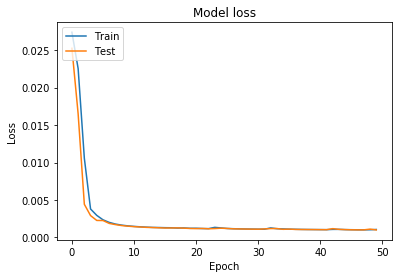

In [0]:
ae = Autoencoder()
ae.train_model(x_train, y_train, x_val, y_val, epochs=50, batch_size=20)

In [0]:
#save the model weights
model_name = "AE_denoising"
model_json = ae.autoencoder_model.to_json()
with open(model_name+".json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
ae.autoencoder_model.save_weights(model_name+".h5")

In [0]:
#Convert h5 to protobuf
!git clone https://github.com/amir-abdi/keras_to_tensorflow.git

Cloning into 'keras_to_tensorflow'...
remote: Enumerating objects: 156, done.
remote: Total 156 (delta 0), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (156/156), 144.73 KiB | 418.00 KiB/s, done.
Resolving deltas: 100% (77/77), done.


In [0]:
!python keras_to_tensorflow/keras_to_tensorflow.py \
    --input_model="/content/AE_denoising.h5" \
    --input_model_json="/content/AE_denoising.json" \
    --output_model="/content/AE_denoising.pb"

##C++ evaluate

In [0]:
!apt-get install build-essential curl git cmake unzip autoconf autogen automake libtool mlocate \
                     zlib1g-dev g++-7 python python3-numpy python3-dev python3-pip python3-wheel wget
!sudo updatedb

In [0]:
!git clone https://github.com/FloopCZ/tensorflow_cc.git
os.chdir("tensorflow_cc")

In [0]:
!ls

build  cmake  CMakeLists.txt


In [0]:
!mkdir build  
os.chdir("build")
# for static library only:
!cmake ..
# for shared library only (requires Bazel):
# cmake -DTENSORFLOW_STATIC=OFF -DTENSORFLOW_SHARED=ON ..
!make && sudo make install #taking a very long time even on GPU

##Prediction on single image

original image


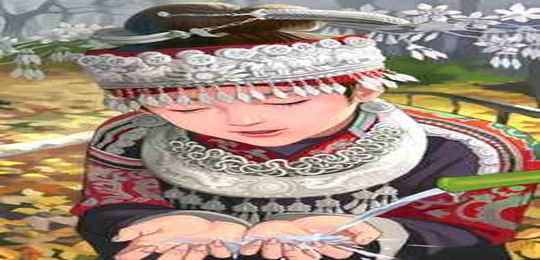

compressed image


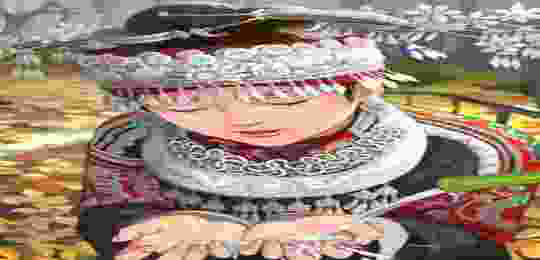

Restored image


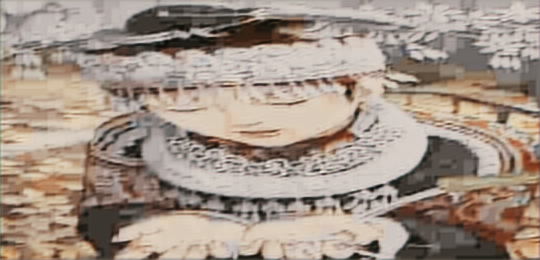

/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


0.6181217733769214

In [0]:
from google.colab.patches import cv2_imshow

file_loc = '/content/dblocking-dataset/validation/set14-downgraded/comic.png'
input_image = Image.open(file_loc)
input_image = input_image.resize((540,260), Image.ANTIALIAS)
img = input_image.resize((540,260), Image.ANTIALIAS)
print("original image")
display(img)

#JPEG compression (uncomment if compression is required)
buffer = BytesIO()
quality = 5
img.save(buffer, "JPEG", quality=quality)
buffer.seek(0)
img = Image.open(io.BytesIO(buffer.read()))
compressed_image = img
print("compressed image")
display(img)


from keras.preprocessing import image

# img = image.load_img(file_loc, color_mode='rgb', target_size=(260, 540))
img = image.img_to_array(img) #.astype('uint8')
img = img / 255.0

# img = np.array(img)


x_input = np.array(img) 


x_input = x_input.reshape((1, 260, 540, 3)) #for cnn model
image = ae.autoencoder_model.predict(x_input)
image = image.reshape((260, 540,3))
restored_image = 1.2*255.0*image
# restored_image = restored_image.astype('uint8')
print("Restored image")
restored_image = cv2.cvtColor(restored_image,  cv2.COLOR_BGR2RGB)
cv2_imshow(restored_image)


# 
input_image = np.array(input_image)
restored_image = np.array(restored_image)
# compressed_image = np.array(compressed_image) 
compare_ssim(input_image, restored_image, multichannel = True)


##Model Evaluation (PSNR and SSIM)

In [0]:
from skimage.measure import compare_psnr, compare_ssim

file_loc = '/content/dblocking-dataset/validation/set14-downgraded/pepper.png'
psnr_arr = []
ssim_arr = []


train_compressed = glob.glob('/content/dblocking-dataset/train/*/*.bmp')
source_dir = train_compressed


        
for idx,i in enumerate(source_dir):
    source_dir = "/".join(i.split("/")[:-1])
    i = i.split("/")[-1]
    
    input_image = Image.open(os.path.join(source_dir,i))
    input_image = input_image.resize((540,260), Image.ANTIALIAS)
    img = input_image.resize((540,260), Image.ANTIALIAS)
#     print("original image")
#     display(img)

    #JPEG compression
    # buffer = BytesIO()
    # quality = 2
    # img.save(buffer, "JPEG", quality=quality)
    # buffer.seek(0)
    # img = Image.open(io.BytesIO(buffer.read()))
    # compressed_image = img
    # print("compressed image")
    # display(img)


    from keras.preprocessing import image

    # img = image.load_img(image_path, color_mode='grayscale', target_size=(258, 540))
    x = image.img_to_array(img).astype('float32')
    img = x / 255.0



    x_input = np.array(img) 


    x_input = x_input.reshape((1, 260, 540, 3)) #for cnn model
    image = ae.autoencoder_model.predict(x_input)
    image = image.reshape((260, 540, 3))
    restored_image = 255.0*image
#     print("Restored image")
#     cv2_imshow(restored_image)


    # 
    input_image = np.array(input_image)
    restored_image = np.array(restored_image)
#     compressed_image = np.array(compressed_image) 
    ssim = compare_ssim(input_image, restored_image, multichannel = True)
    ssim_arr.append(ssim)
    psnr = compare_psnr(input_image, restored_image)
    psnr_arr.append(psnr)
    print("psnr,ssim",psnr,ssim)
    
psnr_avg = sum(psnr_arr)/len(psnr_arr)
ssim_avg = sum(ssim_arr)/len(ssim_arr)
print("psnr_avg",psnr_avg)
print("ssim_avg",ssim_avg)

/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/usr/local/lib/python3.6/dist-packages/skimage/measure/simple_metrics.py:127: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


psnr,ssim 17.609577780806454 0.7623111313307821
psnr,ssim 13.194599555959666 0.8288409705960689
psnr,ssim 20.087251781989025 0.7940109393723388
psnr,ssim 18.484504254549698 0.811667299700328
psnr,ssim 16.06466295349565 0.7153274328804166
psnr,ssim 19.718368649124116 0.6080542723387995
psnr,ssim 18.582362506897617 0.716881879207904
psnr,ssim 19.60896700698064 0.7847409511579357
psnr,ssim 15.603249297940389 0.7228602041983123
psnr,ssim 14.89124243446398 0.6703810216375992
psnr,ssim 19.752526471023387 0.8457059431737096
psnr,ssim 16.6740864682996 0.7488010588652912
psnr,ssim 15.523460368463113 0.7621407321493753
psnr,ssim 13.638148220116534 0.8043938482212462
psnr,ssim 19.665015607369533 0.8102123941629776
psnr,ssim 11.746148610765768 0.6204204518017193
psnr,ssim 20.14283345750718 0.7858564666243844
psnr,ssim 15.012173878404091 0.6802595829873989
psnr,ssim 21.190947162507946 0.7632644019496958
psnr,ssim 18.962412498094537 0.7708225872844608
psnr,ssim 21.237682205040937 0.7936041231232626
